Libraries needed

In [9]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch.nn.functional as F

load demo image and read image properties

In [10]:
filepath = os.path.join(r'/home/banikr2/Downloads', 'Image1.nii.gz')
MR = nib.load(filepath)
MRarray = MR.get_fdata()
print(MRarray.shape)
print(MR.get_qform()) # sagittal, coronal, axial

(91, 109, 91)
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


To visualize one slice

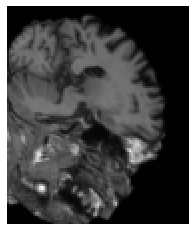

In [11]:
plt.imshow(MRarray[45,...], cmap='gray')
plt.axis('off')
plt.show()

MR orientation was changed to coronal, sagittal and axial orientation(maybe not required)

In [17]:
MR = nib.load(filepath)
MRarray = MR.get_fdata()
# MRarray = np.transpose(MRarray, (1,0,2)) 
MRarray = MRarray[None,...]
MRt = torch.from_numpy(MRarray)
print(type(MRt), MRt.shape)

<class 'torch.Tensor'> torch.Size([1, 91, 109, 91])


In [18]:
wc, ws, wa = 32, 32, 32 # window size 
sc, ss, sa = 32, 32, 32 # stride 

In [19]:
patches = MRt.unfold(1, wc, sc).unfold(2, ws, ss).unfold(3, wa, sa) 
patches.shape

torch.Size([1, 2, 3, 2, 32, 32, 32])

suppose we want to create patches of `32,32,32` so we pad the MR with 0 values(MR air/background) so that all coronal, sagittal and axial dimensions are divisible by 32 or multiples of 32

In [20]:
PaddedMR = F.pad(MRt, (2, 3, 9, 10, 2, 3), 'constant') 
PaddedMR.shape #torch.Size([1, 96, 128, 96])

torch.Size([1, 96, 128, 96])

Visualize padded MR slice

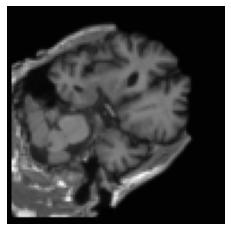

In [21]:
plt.imshow(PaddedMR.numpy()[0, :,64,:],cmap='gray')
plt.axis('off')
plt.show()

Create patches of shape `32,32,32` by `Tensor.unfold`

In [22]:
patches = PaddedMR.unfold(1, wc, sc).unfold(2, ws, ss).unfold(3, wa, sa) 
patches.shape

torch.Size([1, 3, 4, 3, 32, 32, 32])

Final patched compact MR to feed or train NN

In [23]:
unfold_shape = patches.size() 
patches = patches.contiguous().view(-1, wc, ws, wa) 
print(patches.shape) 

torch.Size([36, 32, 32, 32])


Visualize one patch

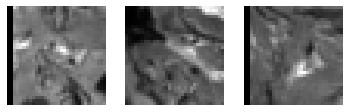

In [24]:
plt.subplot(131)
plt.imshow(patches.numpy()[18,:,16,:],cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(patches.numpy()[18,:,:,16],cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(patches.numpy()[18,16,:,:],cmap='gray')
plt.axis('off')
plt.show()

Reconstruct the original padded MR back

In [25]:
patches_orig = patches.view(unfold_shape) 
output_c = unfold_shape[1] * unfold_shape[4] 
output_h = unfold_shape[2] * unfold_shape[5] 
output_w = unfold_shape[3] * unfold_shape[6] 
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous() 
patches_orig = patches_orig.view(1, output_c, output_h, output_w) 
patches_orig.shape

torch.Size([1, 96, 128, 96])

which is the original padded image size, visualize similarly

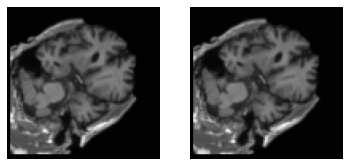

In [26]:
plt.subplot(121)
plt.imshow(PaddedMR.numpy()[0, :,64,:],cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(patches_orig.numpy()[0, :,64,:],cmap='gray')
plt.axis('off')
plt.show()

Now the image can be cropped back to the original size: 

In [29]:
originalMR = np.array(patches_orig[0,0+2:96-3,0+9:128-10,0+2:96-3])
# originalMR = np.transpose(originalMR, ())
print(originalMR.shape, type(originalMR), originalMR.dtype)

(91, 109, 91) <class 'numpy.ndarray'> float64


Compare with original MR

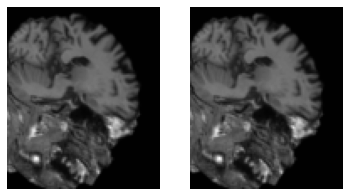

In [30]:
filepath = os.path.join(r'/home/banikr2/Downloads', 'Image1.nii.gz')
MR = nib.load(filepath)
MRarray = MR.get_fdata()
plt.subplot(121)
plt.imshow(MRarray[45,...], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(originalMR[45,...], cmap='gray')
plt.axis('off')
plt.show()